# In class exercises for 11.21.2018 (Filtering)

## First import data from eeg_data00.npz

In [1]:
# first import the modules that you'll need. 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# import our sinc filter implementation function...
import my_sinc_filt as msf

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

## Just like in the first FFT tutorial load eeg_data00.npz so that we have an EEG data set to play with
* you should find that it has three arrays: data, tx, and sr (with 'data' a #trials x # timepoints array containing the EEG data, the time of each data acquisition in tx, and the sample rate stored as sr).  

In [2]:
# load the data...
eeg = np.load('eeg_data00.npz')

# get the different arrays like this...kind of like a structure in matlab. 
eeg['data']
eeg['sr']
eeg['tx']

# and can query the attributes of the data like this...which will tell us that there 960 trials and 876 timepoints per trial sampled
# at 250Hz
print('Shape of the big eeg data set: ', eeg['data'].shape)
print('Sample rate: ', eeg['sr'])

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
# now you can just write data instead of eeg['data'] (and can for tx and sr as well...)

Shape of the big eeg data set:  (960, 876)
Sample rate:  250


## Extract the data from time 0 until time 2000
* hint: you can use boolean indexing by selecting the columns from the 'data' matrix that meet: (tx>=0)  & (tx<2000)
* while you're at it, go ahead and grab the timepoints corresponding to that interval as well

In [3]:
print('tx bounds: ', min(tx),max(tx))

tx bounds:  -1000 2500


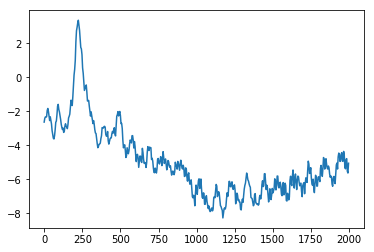

In [4]:
time_low = 0
time_high = 2000

trunc_data = data[:,(tx>=time_low) & (tx<time_high)]
trunc_tx = tx[(tx>=time_low) & (tx<time_high)]

plt.plot(trunc_tx, trunc_data.mean(axis=0))
plt.show()

## Then FFT each trial and take a look at the average power across frequencies
* FFT each trial 
* Then compute the amplitude on each trial
* Then compute the average amplitude across all trials

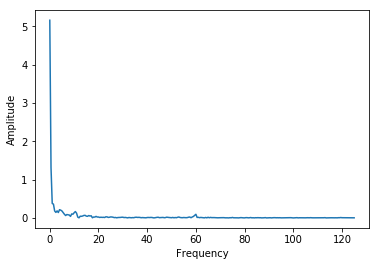

In [8]:
#FFT on trial-averaged signal 

sp = np.fft.rfft(trunc_data.mean(axis=0))
amp = np.abs(sp)  
amp = (amp  / len(trunc_data) ) * 2  
freq = np.fft.rfftfreq(trunc_data[0,:].size, 1/sr) 
plt.plot(freq,amp)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

#### ^^^wrong way to do this-- need to fft each trial, then average

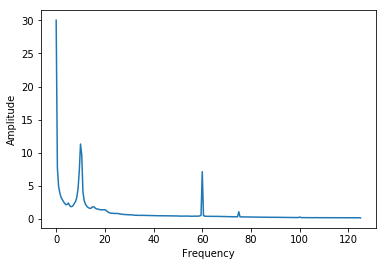

In [9]:
#FFT on each trial, then average

amplitude_array = np.array([])
num_trials = trunc_data.shape[0]
data_points = trunc_data.shape[1]

for i in list(range(num_trials)):
    sp = np.fft.rfft(trunc_data[i,:])
    amp = np.abs(sp)
    amp = (amp/data_points) * 2
    amplitude_array = np.append(amplitude_array, amp, axis = 0)

freq = np.fft.rfftfreq(trunc_data[0,:].size, 1/sr)

amplitude_array_mean = amplitude_array.reshape((num_trials, amp.shape[0]))
amplitude_array_mean = amplitude_array_mean.mean(axis=0)

plt.figure()
plt.plot(freq,amplitude_array_mean)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

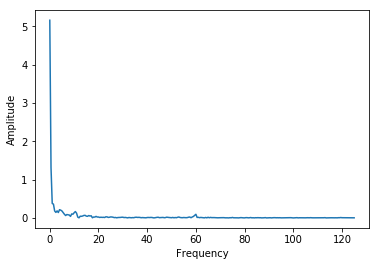

In [10]:
#FFT on trial-averaged signal

sp = np.fft.rfft(trunc_data.mean(axis=0))
amp = np.abs(sp)  
amp = (amp  / len(trunc_data) ) * 2  
freq = np.fft.rfftfreq(trunc_data[0,:].size, 1/sr) 
plt.plot(freq,amp)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

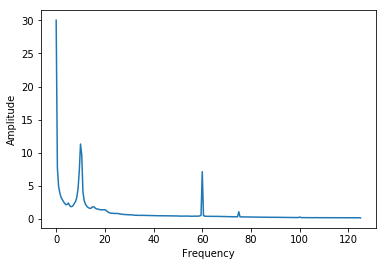

In [12]:
#FFT on each trial, then average

amplitude_array = np.array([])
num_trials = trunc_data.shape[0]
data_points = trunc_data.shape[1]

for i in list(range(num_trials)):
    sp = np.fft.rfft(trunc_data[i,:])
    amp = np.abs(sp)
    amp = (amp/data_points) * 2
    amplitude_array = np.append(amplitude_array, amp, axis = 0)

freq = np.fft.rfftfreq(trunc_data[0,:].size, 1/sr)

amplitude_array_mean = amplitude_array.reshape((num_trials, amp.shape[0]))
amplitude_array_mean = amplitude_array_mean.mean(axis=0)

plt.figure()
plt.plot(freq,amplitude_array_mean)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

## Notice that there are two prominent features in the freq domain representation. Make a lp filter that gets rid of power > 20Hz (you'll know if it worked if you get rid of the spike at 60Hz)
* Because our apply_filter function isn't optimized to work on matrices (we could do that, but haven't) you will need to loop and apply filter to each trial

In [13]:
fc=0.1
b=0.1
win = 'blackman'
type_filt = 'lp'

n, sinc_func = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

filt_sig = np.zeros((num_trials,data_points))
for i in np.arange(num_trials):
    filt_sig[i,:] = msf.apply_filt(input_sig=trunc_data[i,:], input_filter=sinc_func)

## Then FFT it again to see if you got rid of the hf components of the signal

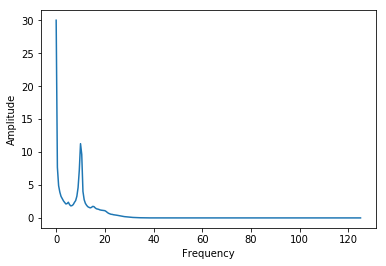

In [14]:
#FFT on each trial, then average

amplitude_array = np.array([])
num_trials = filt_sig.shape[0]
data_points = filt_sig.shape[1]

for i in list(range(num_trials)):
    sp = np.fft.rfft(filt_sig[i,:])
    amp = np.abs(sp)
    amp = (amp/(data_points)) * 2
    amplitude_array = np.append(amplitude_array, amp, axis = 0)

freq = np.fft.rfftfreq(filt_sig[0,:].size, 1/sr)

amplitude_array_mean = amplitude_array.reshape((num_trials, amp.shape[0]))
amplitude_array_mean = amplitude_array_mean.mean(axis=0)

plt.figure()
plt.plot(freq,amplitude_array_mean)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

## Now design a band pass filter that gets rid of everything outside of the 6-14Hz range (where that big bump is...)
* To design a band pass filter, make a lp filter (with an appropriate fc), then make a hp filter (with an appropriate fc)
* use np.convolve to combine the two filters 
* then call the apply_filt function
* Then you should be left with only those frequencies that pass the lp and the hp filters (i.e. a band pass filter)!

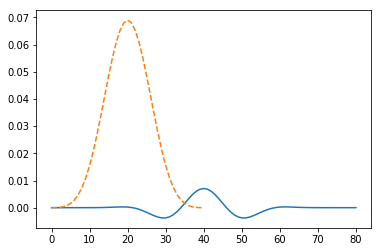

In [15]:
#low pass filter:

fc=6/sr #fc: hz / sampling rate
b=0.1
win = 'blackman'
type_filt = 'lp'

n, sinc_func_low = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

fc=14/sr #fc: hz / sampling rate
b=0.1
win = 'blackman'
type_filt = 'hp'

n, sinc_func_high = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

overall_filt = np.convolve(sinc_func_low,sinc_func_high)
plt.plot(overall_filt)
plt.plot(sinc_func_low, linestyle='--')
# plt.plot(sinc_func_high)


filt_sig = np.zeros((num_trials,data_points))
for i in np.arange(num_trials):
    filt_sig[i,:] = msf.apply_filt(input_sig=trunc_data[i,:], input_filter=overall_filt)

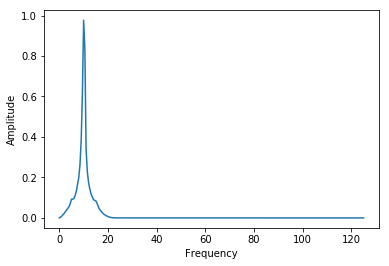

In [16]:
#FFT on each trial, then average

amplitude_array = np.array([])
num_trials = filt_sig.shape[0]
data_points = filt_sig.shape[1]

for i in list(range(num_trials)):
    sp = np.fft.rfft(filt_sig[i,:])
    amp = np.abs(sp)
    amp = (amp/(data_points)) * 2
    amplitude_array = np.append(amplitude_array, amp, axis = 0)

freq = np.fft.rfftfreq(filt_sig[0,:].size, 1/sr)

amplitude_array_mean = amplitude_array.reshape((num_trials, amp.shape[0]))
amplitude_array_mean = amplitude_array_mean.mean(axis=0)

plt.figure()
plt.plot(freq,amplitude_array_mean)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

## You can also make a band-stop filter using a similar logic
* Instead of convolving the lp and the hp filters, you can add them together
* Use this to selectively get rid of the 60Hz line noise in the data by generated a band-stop filter over 50-70Hz

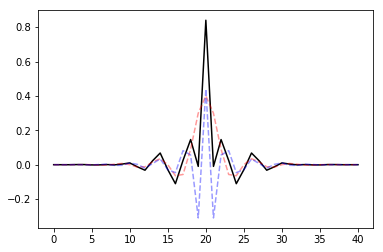

In [17]:
#low pass filter:

fc=50/sr #fc: hz / sampling rate
b=0.1
win = 'blackman'
type_filt = 'lp'

n, sinc_func_low = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

fc=70/sr #fc: hz / sampling rate
b=0.1
win = 'blackman'
type_filt = 'hp'

n, sinc_func_high = msf.define_filt(fc=fc, b=b, window=win, type_filt=type_filt)

overall_filt = sinc_func_low + sinc_func_high
plt.plot(overall_filt, color = 'k')

#plotting original low pass and high pass filters
plt.plot(sinc_func_low, linestyle='--', color = 'r', alpha = 0.4)
plt.plot(sinc_func_high, linestyle='--', color = 'b', alpha = 0.4)
plt.show()


filt_sig = np.zeros((num_trials,data_points))
for i in np.arange(num_trials):
    filt_sig[i,:] = msf.apply_filt(input_sig=trunc_data[i,:], input_filter=overall_filt)

## Then FFT and look at filtered signal in the frequency domain

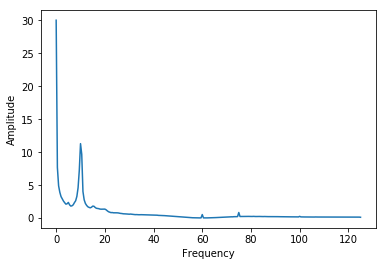

In [18]:
#FFT on each trial, then average

amplitude_array = np.array([])
num_trials = filt_sig.shape[0]
data_points = filt_sig.shape[1]

for i in list(range(num_trials)):
    sp = np.fft.rfft(filt_sig[i,:])
    amp = np.abs(sp)
    amp = (amp/(data_points)) * 2
    amplitude_array = np.append(amplitude_array, amp, axis = 0)

freq = np.fft.rfftfreq(filt_sig[0,:].size, 1/sr)

amplitude_array_mean = amplitude_array.reshape((num_trials, amp.shape[0]))
amplitude_array_mean = amplitude_array_mean.mean(axis=0)

plt.figure()
plt.plot(freq,amplitude_array_mean)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()